In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root
import matplotlib.pyplot as plt

In [23]:
TFtot = 2000
kon = 0.0016399
koff = 0.34393
kbasal = 0.02612
kmax = 13.588
Kd = 956.75
n = 4.203
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.007

p =  kon, TFtot, koff, kbasal, kmax, n, Kd, kdegR, ktrans, kdegP


def khammash_ode(t,x,p,I):
    if callable(I):
        I = I(t)

    # Parameters
    kon, TFtot, koff, kbasal, kmax, n, Kd, kdegR, ktrans, kdegP = p

    # Variables
    TFon, mRNA = x
    TFon = np.max([0,TFon])
    mRNA = mRNA * (kbasal + kmax) / kdegR

    dTFondt = I * kon * (TFtot - TFon) - koff * TFon
    dmRNAdt = kbasal + kmax * (TFon ** n) / ((Kd ** n) + (TFon ** n)) - kdegR * mRNA
    dmRNAdt = dmRNAdt * kdegR / (kbasal + kmax)

    return [dTFondt, dmRNAdt]

def fsolve_func(x,period,I,max_step):
    tspan = [0,period]
    sol = solve_ivp(khammash_ode, t_span=tspan, y0=x, args=(p,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    # return (sol.y[:,:] - x[:])
    return (sol.y[:,-1] - x) * [1/10,10]

def I_fun_base(t, u, period, Imax):
    remainder = t - np.floor(t/period) * period
    I_out = np.zeros(np.array(t).size)
    I_out[remainder < u * period] = Imax
    return I_out

def steady_mRNA_solve(u, period, Imax, x_guess=None):

    I = lambda t: I_fun_base(t, u, period, Imax)

    if x_guess is None:
        x_guess = [100,u]

    if u > 0:
        max_step = u*period
    else:
        max_step = period / 10
    sol = root(fsolve_func, x_guess, args=(period,I,max_step), tol=1e-6)

    steady = np.maximum(sol.x,[0,0])

    return steady, sol.success, sol.message, sol.fun

def opto_growth(t,x,p):

    # Parameters
    kdegR, ktrans, kdegP, mu_max_opto, mu_max_blind, Ks, Y = p

    x_guess = x
    global setpoint
    # if setpoint is None:
    #     out, ier = steady_mRNA_solve(u, period, Imax, x_guess)
    # else:
    #     out = setpoint
    # if ier != 1:
    #     out, ier = steady_mRNA_solve(u, period, Imax, x_guess=None)

    tau_mRNA = 1 / kdegR

    # Variables
    mRNA, Enz_opto, Enz_blind, S, Xopto, Xblind = x
    mRNA_blind = 1

    

    mu_xopto = mu_max_opto * Enz_opto * S / (Ks + S)
    mu_xblind = mu_max_blind * Enz_blind * S / (Ks + S)

    dmRNAdt = (setpoint[1] - mRNA) / tau_mRNA

    Enz_opto = Enz_opto / ((mu_max_opto + kdegP) / ktrans)
    dEnz_optodt = ktrans * mRNA * S / (Ks + S) - (kdegP + mu_xopto) * Enz_opto
    dEnz_optodt = dEnz_optodt * ((mu_max_opto + kdegP) / ktrans)

    Enz_blind = Enz_blind / ((mu_max_blind + kdegP) / ktrans)
    dEnz_blind_optodt = ktrans * mRNA_blind * S / (Ks + S) - (kdegP + mu_xblind) * Enz_blind
    dEnz_blind_optodt = dEnz_blind_optodt * ((mu_max_blind + kdegP) / ktrans)


    dSdt = - (mu_xopto / Y) * Xopto - (mu_xblind / Y) * Xblind
    dX_optodt = mu_xopto * Xopto
    dX_blind_optodt = mu_xblind * Xblind



    return [dmRNAdt, dEnz_optodt, dEnz_blind_optodt, dSdt, dX_optodt, dX_blind_optodt]


my setpoint
True
The solution converged.
[1.95891639e+03 9.53198326e-01]
0
The solver successfully reached the end of the integration interval.
True


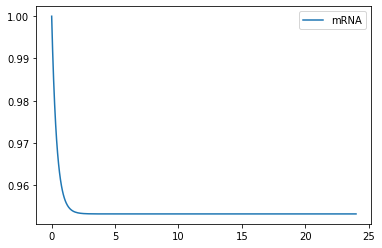

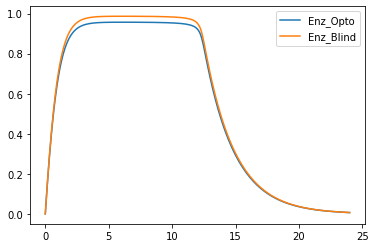

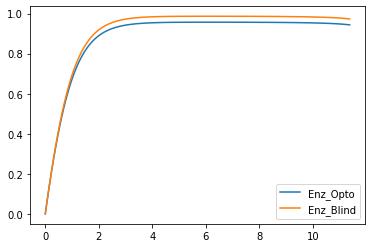

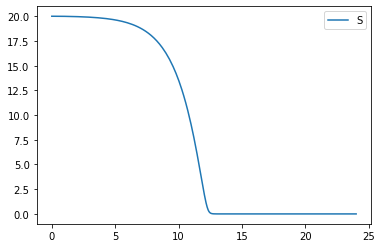

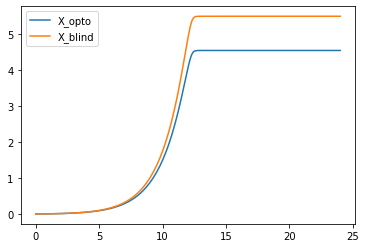

In [31]:
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.007

kdegP = 0.007

mu_max_opto = 2/200
mu_max_blind = mu_max_opto
Ks = 1
Y = 0.5

optogrowth_p = kdegR, ktrans, kdegP, mu_max_opto, mu_max_blind, Ks, Y

# mRNA, Enz_opto, Enz_blind, S, Xopto, Xblind
x_init = [1, 0, 0, 20, 0.01, 0.01]

u = 1
period = 100 / 60
Imax = 10000

setpoint, ier, mesg, _ = steady_mRNA_solve(u, period, Imax, x_guess=None)

print('my setpoint')
print(ier)
print(mesg)
print(setpoint)

I = lambda t: I_fun_base(t, u, period, Imax)

if u > 0:
    max_step = u*period
else:
    max_step = period / 10

tspan = [0, 24*60]

sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init, args=(optogrowth_p,),
                    rtol=1e-6, atol=1e-9, 
                    # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                    method='BDF',
                    first_step = 0.0001,
                    # max_step=max_step,
                    )

print(sol.status)
print(sol.message)
print(sol.success)

plt.figure(facecolor='white')
plt.plot(sol.t/60, sol.y[0,:], label='mRNA')
plt.legend()

plt.figure(facecolor='white')
plt.plot(sol.t/60, sol.y[1,:], label='Enz_Opto')
plt.plot(sol.t/60, sol.y[2,:], label='Enz_Blind')
plt.legend()

rangeme = 100
plt.figure(facecolor='white')
plt.plot(sol.t[:rangeme]/60, sol.y[1,:][:rangeme], label='Enz_Opto')
plt.plot(sol.t[:rangeme]/60, sol.y[2,:][:rangeme], label='Enz_Blind')
plt.legend()

plt.figure(facecolor='white')
plt.plot(sol.t/60, sol.y[3,:], label='S')
plt.legend()

plt.figure(facecolor='white')
plt.plot(sol.t/60, sol.y[4,:], label='X_opto')
plt.plot(sol.t/60, sol.y[5,:], label='X_blind')
plt.legend()

In [4]:
# Enz_blind = Enz_blind / ((mu_max_blind + kdegP) / ktrans)
# dEnz_blind_optodt = ktrans * mRNA_blind - (kdegP + mu_xopto) * Enz_opto
# dEnz_blind_optodt = dEnz_blind_optodt * ((mu_max_blind + kdegP) / ktrans)


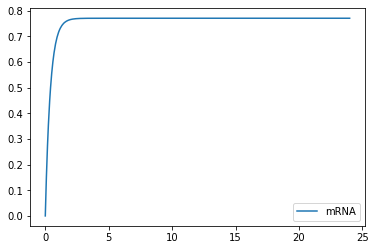

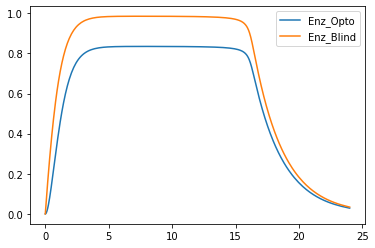

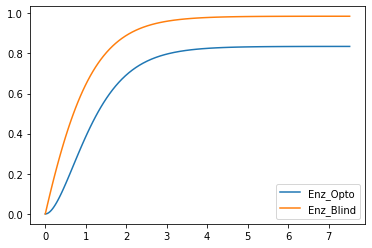

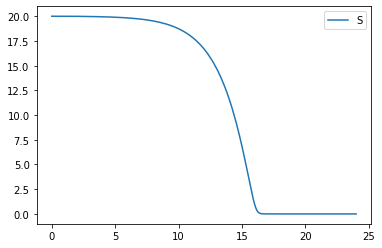

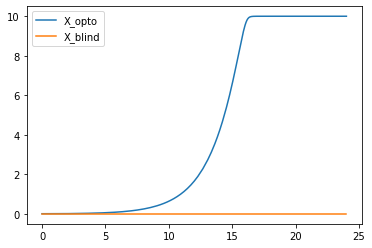

In [5]:
plt.figure(facecolor='white')
plt.plot(sol.t/60, sol.y[0,:], label='mRNA')
plt.legend()

plt.figure(facecolor='white')
plt.plot(sol.t/60, sol.y[1,:], label='Enz_Opto')
plt.plot(sol.t/60, sol.y[2,:], label='Enz_Blind')
plt.legend()

rangeme = 100
plt.figure(facecolor='white')
plt.plot(sol.t[:rangeme]/60, sol.y[1,:][:rangeme], label='Enz_Opto')
plt.plot(sol.t[:rangeme]/60, sol.y[2,:][:rangeme], label='Enz_Blind')
plt.legend()

plt.figure(facecolor='white')
plt.plot(sol.t/60, sol.y[3,:], label='S')
plt.legend()

plt.figure(facecolor='white')
plt.plot(sol.t/60, sol.y[4,:], label='X_opto')
plt.plot(sol.t/60, sol.y[5,:], label='X_blind')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1.0
my setpoint
True
The solution converged.
[1.95891639e+03 9.53198326e-01]
0
The solver successfully reached the end of the integration interval.
True
0.0
my setpoint
True
The solution converged.
[0.        0.0019186]
0
The solver successfully reached the end of the integration interval.
True


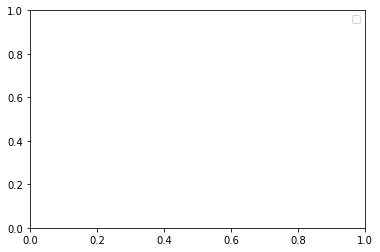

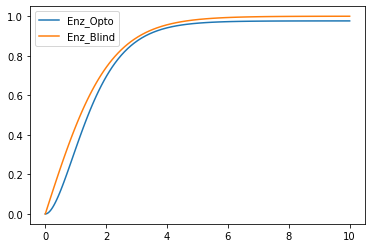

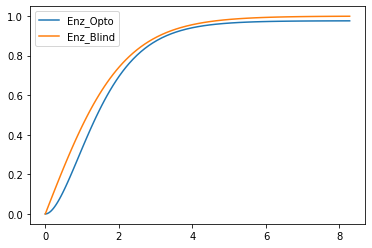

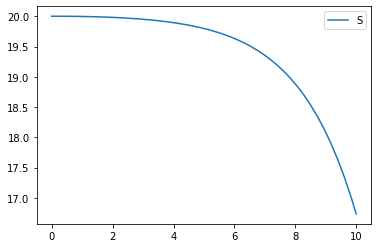

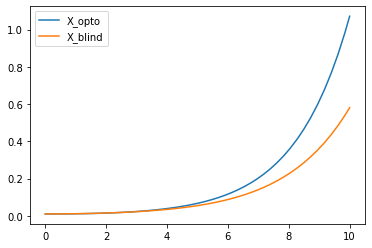

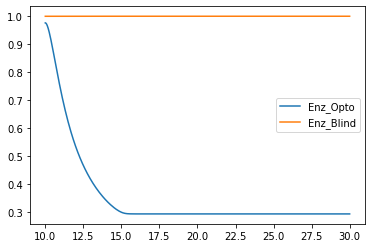

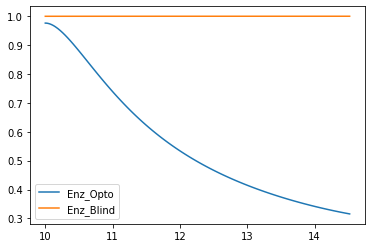

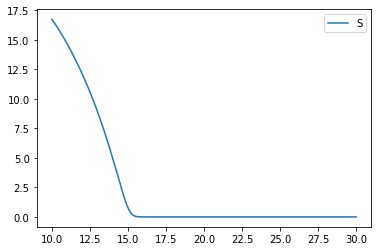

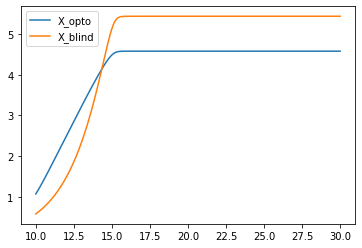

In [6]:
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.00

mu_max_opto = 2/200
mu_max_blind = mu_max_opto/1.2
Ks = 1
Y = 0.5

optogrowth_p = kdegR, ktrans, kdegP, mu_max_opto, mu_max_blind, Ks, Y

# mRNA, Enz_opto, Enz_blind, S, Xopto, Xblind
x_init = [0, 0, 0, 20, 0.01, 0.01]

u_arr = [1.00, 0.00]
tspan_arr = [0, 10, 30]

sol_arr = []
t_arr = []

for i in range(len(u_arr)):
    u = u_arr[i]
    period = 100 / 60
    Imax = 10000

    setpoint, ier, mesg, _ = steady_mRNA_solve(u, period, Imax, x_guess=None)

    print(u)
    print('my setpoint')
    print(ier)
    print(mesg)
    print(setpoint)

    I = lambda t: I_fun_base(t, u, period, Imax)

    if u > 0:
        max_step = u*period
    else:
        max_step = period / 10

    tspan = np.array([tspan_arr[i], tspan_arr[i+1]])*60

    sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init, args=(optogrowth_p,),
                        rtol=1e-6, atol=1e-9, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        # max_step=max_step,
                        )
    print(sol.status)
    print(sol.message)
    print(sol.success)

    sol_arr.append(sol.y)
    t_arr.append(sol.t)
    x_init = sol.y[:,-1]


    plt.legend()

    plt.figure(facecolor='white')
    plt.plot(sol.t/60, sol.y[1,:], label='Enz_Opto')
    plt.plot(sol.t/60, sol.y[2,:], label='Enz_Blind')
    plt.legend()

    rangeme = 100
    plt.figure(facecolor='white')
    plt.plot(sol.t[:rangeme]/60, sol.y[1,:][:rangeme], label='Enz_Opto')
    plt.plot(sol.t[:rangeme]/60, sol.y[2,:][:rangeme], label='Enz_Blind')
    plt.legend()

    plt.figure(facecolor='white')
    plt.plot(sol.t/60, sol.y[3,:], label='S')
    plt.legend()

    plt.figure(facecolor='white')
    plt.plot(sol.t/60, sol.y[4,:], label='X_opto')
    plt.plot(sol.t/60, sol.y[5,:], label='X_blind')
    plt.legend()

soly = np.concatenate(sol_arr, axis=1)
solt = np.concatenate(t_arr, axis=0)


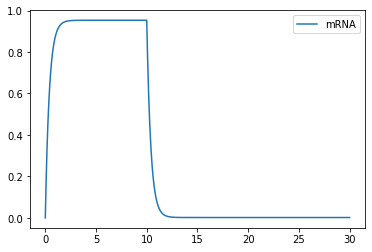

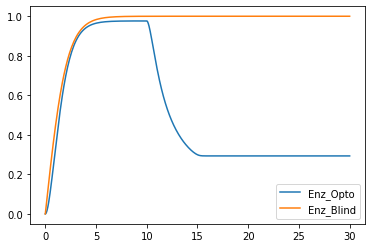

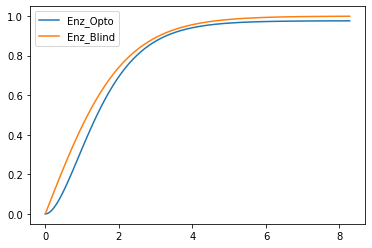

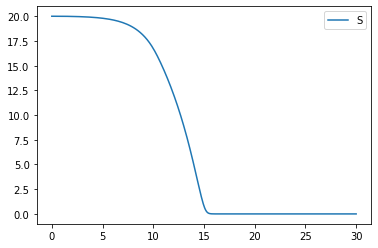

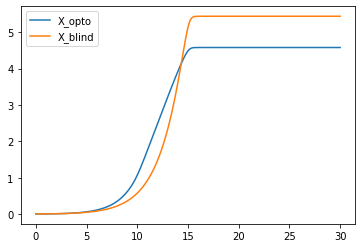

In [7]:
plt.figure(facecolor='white')
plt.plot(solt/60, soly[0,:], label='mRNA')
plt.legend()

plt.figure(facecolor='white')
plt.plot(solt/60, soly[1,:], label='Enz_Opto')
plt.plot(solt/60, soly[2,:], label='Enz_Blind')
plt.legend()

rangeme = 100
plt.figure(facecolor='white')
plt.plot(solt[:rangeme]/60, soly[1,:][:rangeme], label='Enz_Opto')
plt.plot(solt[:rangeme]/60, soly[2,:][:rangeme], label='Enz_Blind')
plt.legend()

plt.figure(facecolor='white')
plt.plot(solt/60, soly[3,:], label='S')
plt.legend()

plt.figure(facecolor='white')
plt.plot(solt/60, soly[4,:], label='X_opto')
plt.plot(solt/60, soly[5,:], label='X_blind')
plt.legend()

0
0.01
0.02
0.05
0.1
1.0


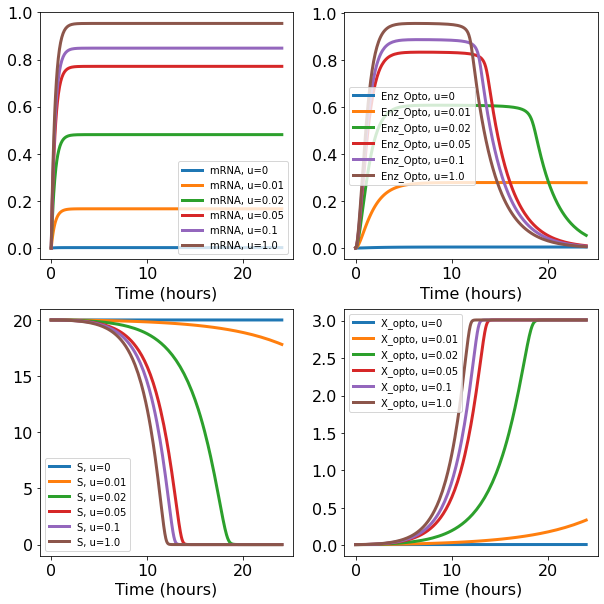

In [8]:
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.007

mu_max_opto = 2/200
mu_max_blind = mu_max_opto/1.2
Ks = 1
Y = 0.15

optogrowth_p = kdegR, ktrans, kdegP, mu_max_opto, mu_max_blind, Ks, Y

# mRNA, Enz_opto, Enz_blind, S, Xopto, Xblind
x_init = [0, 0, 0, 20, 0.01, 0.0]

u = 0.05
u_arr = [0, 0.01, 0.02, 0.05, 0.1, 1.0]
# u_arr = [0, 1.0]

plt.figure(figsize=(10,10),facecolor='white')
axes = []
for i in range(4):
    axes.append(plt.subplot(2,2,i+1))

for i in range(len(u_arr)):
    u = u_arr[i]
    print(u)

    period = 100 / 60
    Imax = 10000

    setpoint, ier, mesg, _ = steady_mRNA_solve(u, period, Imax, x_guess=None)

    # print('my setpoint')
    # print(ier)
    # print(mesg)
    # print(setpoint)

    I = lambda t: I_fun_base(t, u, period, Imax)

    if u > 0:
        max_step = u*period
    else:
        max_step = period / 10

    tspan = [0, 24*60]

    sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init, args=(optogrowth_p,),
                        rtol=1e-6, atol=1e-9, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        # max_step=max_step,
                        )

    axes[0].plot(sol.t/60, sol.y[0,:], label='mRNA, u=' + str(u), linewidth=3, c='C'+str(i), linestyle='solid')
    axes[1].plot(sol.t/60, sol.y[1,:], label='Enz_Opto, u=' + str(u), linewidth=3, c='C'+str(i), linestyle='solid')
    # axes[1].plot(sol.t/60, sol.y[2,:], label='Enz_Blind, u=' + str(u), linewidth=3, c='C'+str(i), linestyle='dashed')
    axes[2].plot(sol.t/60, sol.y[3,:], label='S, u=' + str(u), linewidth=3, c='C'+str(i), linestyle='solid')
    axes[3].plot(sol.t/60, sol.y[4,:], label='X_opto, u=' + str(u), linewidth=3, c='C'+str(i), linestyle='solid')
    # axes[3].plot(sol.t/60, sol.y[5,:], label='X_blind, u=' + str(u), linewidth=3, c='C'+str(i), linestyle='dashed')

    # print(sol.status)
    # print(sol.message)
    # print(sol.success)

for i in range(4):
    axes[i].legend()
    axes[i].set_xlabel('Time (hours)', fontsize=16)
    axes[i].tick_params(axis='both', which='major', labelsize=16)
    



0
0.01
0.05
0.1
1.0


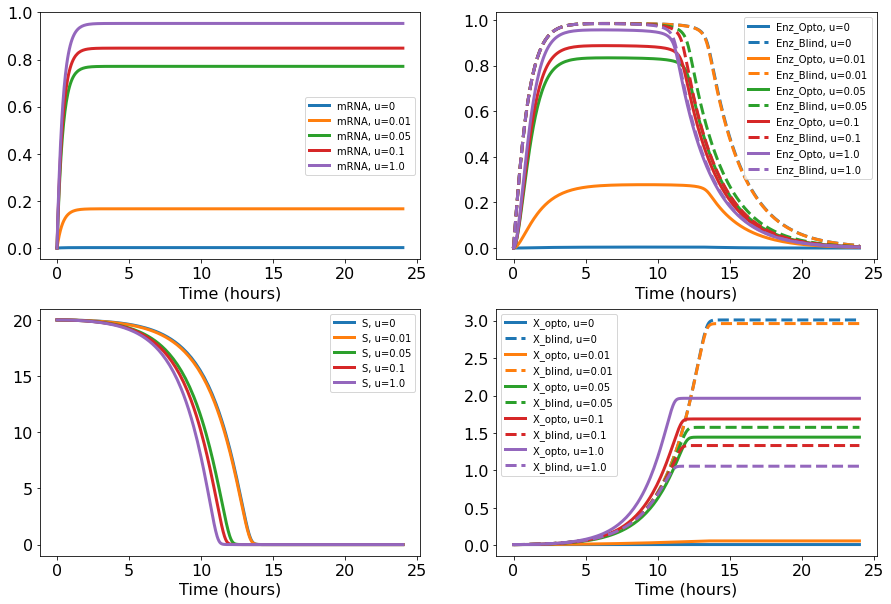

In [9]:
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.007

mu_max_opto = 2/200
mu_max_blind = mu_max_opto/1.2
Ks = 1
Y = 0.15

optogrowth_p = kdegR, ktrans, kdegP, mu_max_opto, mu_max_blind, Ks, Y

# mRNA, Enz_opto, Enz_blind, S, Xopto, Xblind
x_init = [0, 0, 0, 20, 0.01, 0.01]

u = 0.05
u_arr = [0, 0.01, 0.05, 0.1, 1.0]
# u_arr = [0, 1.0]

plt.figure(figsize=(15,10),facecolor='white')
axes = []
for i in range(4):
    axes.append(plt.subplot(2,2,i+1))

for i in range(len(u_arr)):
    u = u_arr[i]
    print(u)

    period = 100 / 60
    Imax = 10000

    setpoint, ier, mesg, _ = steady_mRNA_solve(u, period, Imax, x_guess=None)

    # print('my setpoint')
    # print(ier)
    # print(mesg)
    # print(setpoint)

    I = lambda t: I_fun_base(t, u, period, Imax)

    if u > 0:
        max_step = u*period
    else:
        max_step = period / 10

    tspan = [0, 24*60]

    sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init, args=(optogrowth_p,),
                        rtol=1e-6, atol=1e-9, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        # max_step=max_step,
                        )

    axes[0].plot(sol.t/60, sol.y[0,:], label='mRNA, u=' + str(u), linewidth=3, c='C'+str(i), linestyle='solid')
    axes[1].plot(sol.t/60, sol.y[1,:], label='Enz_Opto, u=' + str(u), linewidth=3, c='C'+str(i), linestyle='solid')
    axes[1].plot(sol.t/60, sol.y[2,:], label='Enz_Blind, u=' + str(u), linewidth=3, c='C'+str(i), linestyle='dashed')
    axes[2].plot(sol.t/60, sol.y[3,:], label='S, u=' + str(u), linewidth=3, c='C'+str(i), linestyle='solid')
    axes[3].plot(sol.t/60, sol.y[4,:], label='X_opto, u=' + str(u), linewidth=3, c='C'+str(i), linestyle='solid')
    axes[3].plot(sol.t/60, sol.y[5,:], label='X_blind, u=' + str(u), linewidth=3, c='C'+str(i), linestyle='dashed')

    # print(sol.status)
    # print(sol.message)
    # print(sol.success)

for i in range(4):
    axes[i].legend()
    axes[i].set_xlabel('Time (hours)', fontsize=16)
    axes[i].tick_params(axis='both', which='major', labelsize=16)
    



0
0.01
0.025
0.1
1.0


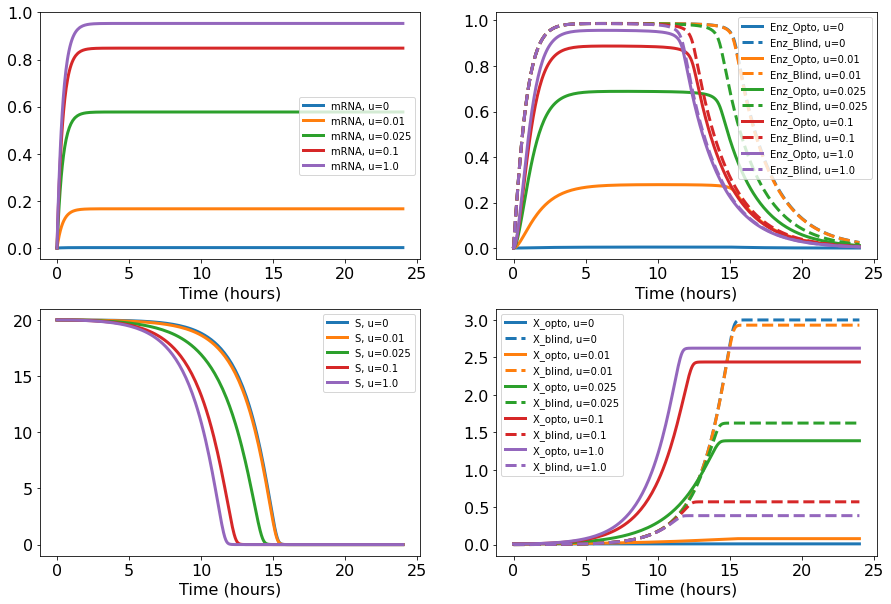

In [10]:
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.007

mu_max_opto = 2/200
mu_max_blind = mu_max_opto
Ks = 1
Y = 0.15

optogrowth_p = kdegR, ktrans, kdegP, mu_max_opto, mu_max_blind, Ks, Y

# mRNA, Enz_opto, Enz_blind, S, Xopto, Xblind
x_init = [0, 0, 0, 20, 0.01, 0.001]

u = 0.05
u_arr = [0, 0.01, 0.025, 0.1, 1.0]
# u_arr = [0, 1.0]

plt.figure(figsize=(15,10))
axes = []
for i in range(4):
    axes.append(plt.subplot(2,2,i+1))

for i in range(len(u_arr)):
    u = u_arr[i]
    print(u)

    period = 100 / 60
    Imax = 10000

    setpoint, ier, mesg, _ = steady_mRNA_solve(u, period, Imax, x_guess=None)

    # print('my setpoint')
    # print(ier)
    # print(mesg)
    # print(setpoint)

    I = lambda t: I_fun_base(t, u, period, Imax)

    if u > 0:
        max_step = u*period
    else:
        max_step = period / 10

    tspan = [0, 24*60]

    sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init, args=(optogrowth_p,),
                        rtol=1e-6, atol=1e-9, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        # max_step=max_step,
                        )

    axes[0].plot(sol.t/60, sol.y[0,:], label='mRNA, u=' + str(u), linewidth=3, c='C'+str(i), linestyle='solid')
    axes[1].plot(sol.t/60, sol.y[1,:], label='Enz_Opto, u=' + str(u), linewidth=3, c='C'+str(i), linestyle='solid')
    axes[1].plot(sol.t/60, sol.y[2,:], label='Enz_Blind, u=' + str(u), linewidth=3, c='C'+str(i), linestyle='dashed')
    axes[2].plot(sol.t/60, sol.y[3,:], label='S, u=' + str(u), linewidth=3, c='C'+str(i), linestyle='solid')
    axes[3].plot(sol.t/60, sol.y[4,:], label='X_opto, u=' + str(u), linewidth=3, c='C'+str(i), linestyle='solid')
    axes[3].plot(sol.t/60, sol.y[5,:], label='X_blind, u=' + str(u), linewidth=3, c='C'+str(i), linestyle='dashed')

    # print(sol.status)
    # print(sol.message)
    # print(sol.success)

for i in range(4):
    axes[i].legend()
    axes[i].set_xlabel('Time (hours)', fontsize=16)
    axes[i].tick_params(axis='both', which='major', labelsize=16)
    

